# Setup

In [1]:
import numpy as np
import torch, pyro, random, IPython
import pyro.distributions as dist
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')
pyro.set_rng_seed(1)

c:\program files\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model & Guide

In [2]:
def model(wins, var_names, has_optimal, X_blue, X_red):
    var_weights  = []
    optimal_vars = []
    
    for i in pyro.plate('vars', len(var_names)):
        var_weights .append(pyro.sample(f'{var_names[i]}_weight' , dist.Normal(0., 1.)))
        optimal_vars.append(pyro.sample(f'{var_names[i]}_optimal', dist.Normal(0., 1.))
                            if has_optimal[i] else torch.tensor(0.))
    
    for i in pyro.plate('games', len(wins)):
        blue_score = torch.tensor([0.])
        red_score  = torch.tensor([0.])
        
        for blue_val, red_val, optimal, weight in zip(
            X_blue[i], X_red[i], optimal_vars, var_weights):
            blue_score += (optimal - blue_val).square() * weight
            red_score  += (optimal - red_val ).square() * weight
        
        pyro.sample(f'W_{i}', dist.Bernoulli(logits=blue_score-red_score)
                    , obs=torch.tensor(float(wins[i])))

In [3]:
def guide(wins, var_names, has_optimal, X_blue, X_red):
    optim_means = []
    optim_vars = []
    weight_means = []
    weight_vars = []
    
    for i in pyro.plate('vars', len(var_names)):
        if has_optimal[i]:
            optim_mean = pyro.param(f'{var_names[i]}_optimal_mean', torch.tensor(0.))
            optim_var = pyro.param(f'{var_names[i]}_optimal_var', torch.tensor(1.),
                                  constraint=dist.constraints.positive)
            pyro.sample(f'{var_names[i]}_optimal', dist.Normal(optim_mean,  optim_var))
        else:
            optim_mean = torch.tensor(0.)
            optim_var = torch.tensor(0.)
        
        weight_mean = pyro.param(f'{var_names[i]}_weight_mean', torch.tensor(0.))
        weight_var  = pyro.param(f'{var_names[i]}_weight_var', torch.tensor(1.),
                               constraint=dist.constraints.positive)
        pyro.sample(f'{var_names[i]}_weight' , dist.Normal(weight_mean, weight_var))
        
        optim_means.append(optim_mean)
        optim_vars .append(optim_var)
        weight_means.append(weight_mean)
        weight_vars .append(weight_var)
        
    return optim_means, optim_vars, weight_means, weight_vars

# Load Data

In [4]:
#load dataframe; then normalize to [0,1], saving min/max for rescaling
df = pd.read_csv('./raw/league.csv').drop('gameId', axis=1)
all_vars = tuple(set(c.lstrip('redblu') for c in df.columns if c != 'blueWins'))
blue_vars = ['blue'+v for v in all_vars]
red_vars  = ['red' +v for v in all_vars]
#offset so min 0 (shared across red/blue teams)
b_min = df[blue_vars][:].min().to_numpy()
r_min = df[red_vars ][:].min().to_numpy()
d_min = np.minimum(b_min,r_min)
df_0 = df.copy()
df_0[blue_vars] -= d_min
df_0[red_vars]  -= d_min
#repeat for scaling max=1
b0_max = df_0[blue_vars][:].max().to_numpy()
r0_max = df_0[red_vars ][:].max().to_numpy()
d0_max = np.maximum(b0_max,r0_max)
df_norm = df_0 #no need for extra copy
df_norm[blue_vars] /= d0_max
df_norm[red_vars]  /= d0_max
#convert min/max back to pandas.Series for later rescaling
df_min = pd.Series(data=d_min,  index = all_vars)
df_max = pd.Series(data=d0_max, index = all_vars)

In [5]:
wins = df['blueWins'].to_numpy()

## Helpers

In [6]:
def set_vars(var_list, all_optimal=True):
    '''used to set variables before training'''
    global has_optimal, var_names, X_blue, X_red
    var_names = var_list
    has_optimal = [all_optimal for _ in var_names]
    blue_vars = ['blue'+v for v in var_names]
    red_vars  = ['red' +v for v in var_names]
    X_blue = df_norm[blue_vars].to_numpy()
    X_red  = df_norm[red_vars ].to_numpy()

In [7]:
def rescale(optimal, var):
    return optimal*df_max[var] + df_min[var]

In [8]:
def print_vars(show_variance=False):
    optim_means, optim_var, weight_means, weight_var = guide(
        wins, var_names, has_optimal, X_blue, X_red)

    for i, label in enumerate(var_names):
        print(label)
        print(f'\tweight mean: {weight_means[i]}')
        if show_variance: print(f'\tweight var : {weight_var[i]}')
        if has_optimal[i]:
            om = optim_means[i].detach().item()
            print(f'\toptimal mean:     {om}')
            print('\toptimal rescaled:',rescale(om,label)
                  if om > 0 else 'N/A (optim <= 0)')
            if show_variance: print(f'\toptimal var :     {optim_var[i]}')
        else:
            print('\toptimal: N/A')

In [9]:
def team_score(optimals,weights,X): 
    return ((optimals-X)**2 * weights).sum(axis=1)

In [10]:
def accuracy(optimals, weights): 
    t1 = team_score(optimals, weights, X_blue)
    t2 = team_score(optimals, weights, X_red)
    combined_scores = np.vstack((t1,t2)).T
    #since win is 'blueWins', use argmin for win=1 when blue > red
    Y_hat = combined_scores.argmin(axis=1)
    return (Y_hat == wins).mean()

In [11]:
def append_vars(var_list, accuracies):
    om, _, wm, _ = guide(wins, var_names, has_optimal, X_blue, X_red)
    om_np = np.array([o.detach().numpy() for o in om])
    wm_np = np.array([w.detach().numpy() for w in wm])
    var_list.append([wm_np, om_np])
    accuracies.append(accuracy(om_np, wm_np))

# Training the Model(s)

In [12]:
total = len(wins)
optimizer = pyro.optim.Adam({'lr': 0.01})

## Helpers

In [13]:
def train(steps = 200, batch_size = 50):
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
    vars_plot = []
    accuracies = []
    
    for step in range(1, steps + 1):
        indices = np.unique(np.random.randint(0,total, size=batch_size))
        mask = [True if i in indices else False for i in range(total)]
        svi.step(wins[mask], var_names, has_optimal, X_blue[mask], X_red[mask])
        if step % 10 == 0:
            IPython.display.clear_output(wait=True)
            print(f'{100 * step / steps:.1f}% complete')
            append_vars(vars_plot, accuracies)
    return np.array(vars_plot), accuracies

In [14]:
def plot_model(var_list, vars_arr, acc_arr):
    '''plot optimals & weights, as well as accuracies'''
    l = len(vars_arr)
    fig, ax = plt.subplots(2,1, figsize = (6, 10))
    ax[0].set(title="Weights over steps", 
                xlabel='Step',
                ylabel='Weight')
    ax[1].set(title="Optimal ratio over steps" if any(has_optimal) else "Optimal Ratios (Empty)", 
                xlabel='Step',
                    ylabel='Ratio')
    for i in range(len(var_list)):
        ax[0].plot(range(l), vars_arr[:,0,i], label = var_list[i])
        
        if(has_optimal[i]):
            ax[1].plot(range(l), vars_arr[:,1,i], label = var_list[i]
                       , c=ax[0].get_lines()[-1].get_c())
    
    ax[0].legend(bbox_to_anchor=(1.04,0), loc = 'center left')
    plt.show()

    fig2 = plt.figure()
    plt.title("Accuracy over steps")
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.plot(range(l), acc_arr)
    plt.show()

## Model 1

Full run with all features (The graph will be hard to read.)

In [15]:
%%time
vars1 = all_vars #defined when loading data
set_vars(vars1)

vars_np1, accuracies1 = train(steps = 1000, batch_size = 100)
%store vars_np1 accuracies1

100.0% complete
Stored 'vars_np1' (ndarray)
Stored 'accuracies1' (list)
Wall time: 6min 27s


In [16]:
%store -r vars_np1 accuracies1

In [17]:
print_vars()

TotalExperience
	weight mean: 0.7251161932945251
	optimal mean:     -0.37370216846466064
	optimal rescaled: N/A (optim <= 0)
TowersDestroyed
	weight mean: 0.0588095523416996
	optimal mean:     -0.17792361974716187
	optimal rescaled: N/A (optim <= 0)
EliteMonsters
	weight mean: 0.23160244524478912
	optimal mean:     0.002143200021237135
	optimal rescaled: 0.00428640004247427
Kills
	weight mean: 0.3740754723548889
	optimal mean:     -0.11246510595083237
	optimal rescaled: N/A (optim <= 0)
GoldDiff
	weight mean: 0.7410467863082886
	optimal mean:     -0.4319738745689392
	optimal rescaled: N/A (optim <= 0)
Heralds
	weight mean: 0.06824897229671478
	optimal mean:     0.4653870463371277
	optimal rescaled: 0.4653870463371277
ExperienceDiff
	weight mean: 0.590256929397583
	optimal mean:     -0.3467310965061188
	optimal rescaled: N/A (optim <= 0)
WardsDestroyed
	weight mean: 0.08728671073913574
	optimal mean:     0.0037826262414455414
	optimal rescaled: 0.10213090851902962
TotalMinionsKilled
	we

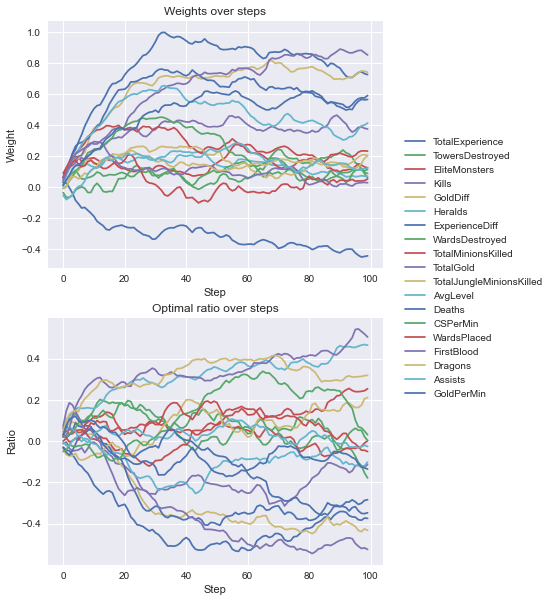

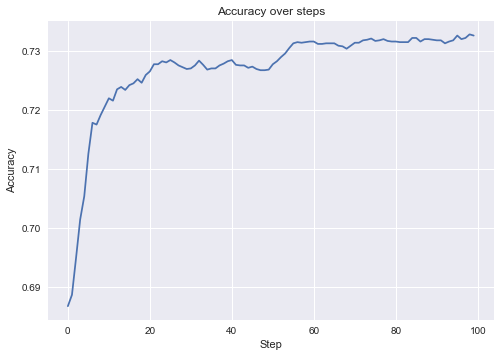

In [18]:
plot_model(vars1, vars_np1, accuracies1)

## Model 2

Simple test with 5 (randomly selected) features

In [19]:
%%time
vars2 = ['WardsPlaced', 'TotalGold', 'TotalJungleMinionsKilled']
set_vars(vars2)

vars_np2, accuracies2 = train(steps = 1000, batch_size = 250)
%store vars_np2 accuracies2

100.0% complete
Stored 'vars_np2' (ndarray)
Stored 'accuracies2' (list)
Wall time: 4min 4s


In [20]:
%store -r vars_np2 accuracies2

In [21]:
print_vars(True)

WardsPlaced
	weight mean: -0.031057264655828476
	weight var : 0.7007563710212708
	optimal mean:     0.22455495595932007
	optimal rescaled: 65.85439306497574
	optimal var :     0.6886417269706726
TotalGold
	weight mean: 1.8157950639724731
	weight var : 0.2975007891654968
	optimal mean:     -1.5071232318878174
	optimal rescaled: N/A (optim <= 0)
	optimal var :     0.3066461980342865
TotalJungleMinionsKilled
	weight mean: 0.19862215220928192
	weight var : 0.5798856616020203
	optimal mean:     0.028601380065083504
	optimal rescaled: 2.6313269659876823
	optimal var :     0.6742196083068848


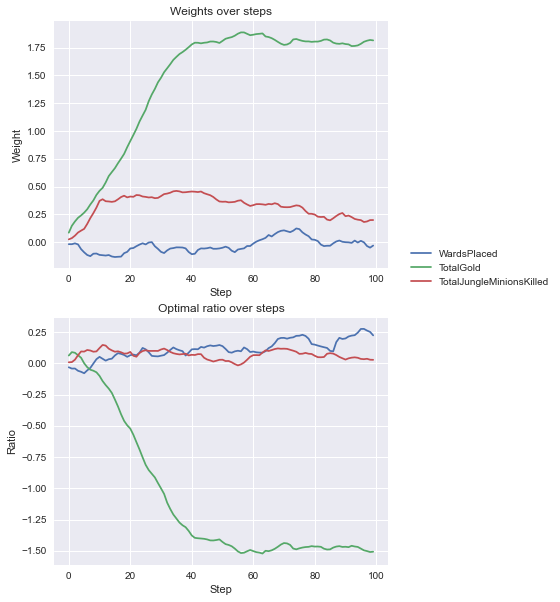

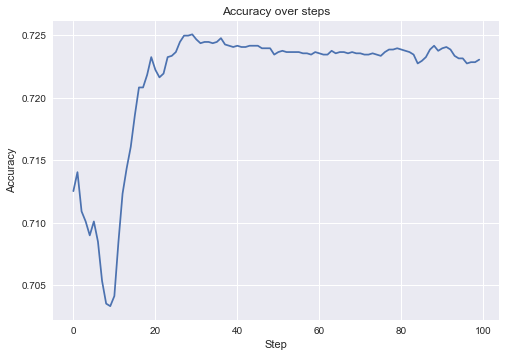

In [22]:
plot_model(vars2, vars_np2, accuracies2)

## Model 3

Model 2, with some extra features.

In [23]:
%%time
vars3 = ['WardsPlaced', 'TotalGold', 'ExperienceDiff', 'EliteMonsters', 'TotalJungleMinionsKilled']
set_vars(vars3)

vars_np3, accuracies3 = train(steps = 1000, batch_size = 200)
%store vars_np3 accuracies3

100.0% complete
Stored 'vars_np3' (ndarray)
Stored 'accuracies3' (list)
Wall time: 4min 51s


In [24]:
%store -r vars_np3 accuracies3

In [25]:
print_vars()

WardsPlaced
	weight mean: -0.09037141501903534
	optimal mean:     0.07555853575468063
	optimal rescaled: 25.47636318951845
TotalGold
	weight mean: 1.4113510847091675
	optimal mean:     -1.141167163848877
	optimal rescaled: N/A (optim <= 0)
ExperienceDiff
	weight mean: 1.0051275491714478
	optimal mean:     -0.6813950538635254
	optimal rescaled: N/A (optim <= 0)
EliteMonsters
	weight mean: 0.292564332485199
	optimal mean:     0.013644245453178883
	optimal rescaled: 0.027288490906357765
TotalJungleMinionsKilled
	weight mean: 0.06842083483934402
	optimal mean:     0.28018662333488464
	optimal rescaled: 25.777169346809387


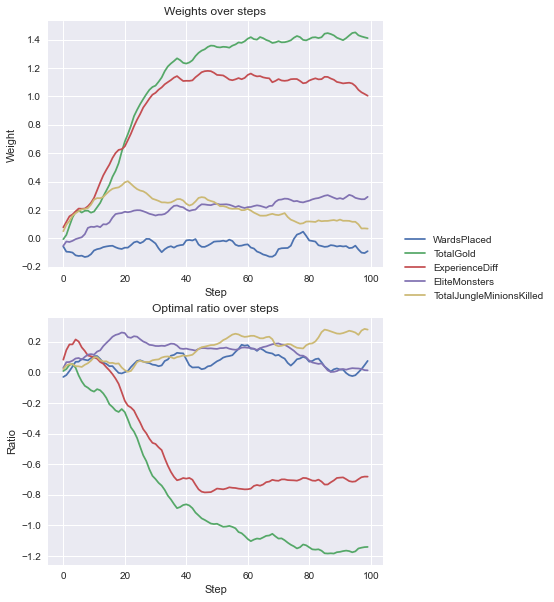

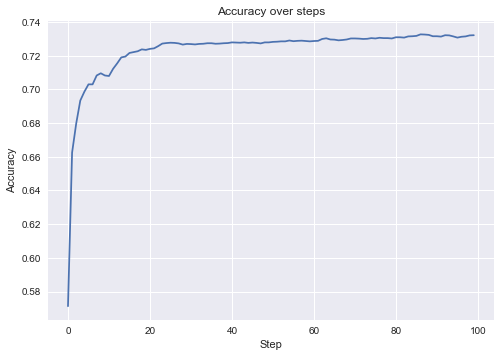

In [26]:
plot_model(vars3, vars_np3, accuracies3)

## Model 4

Same features as Model 3, with some has_optimal changed.

In [27]:
%%time
set_vars(vars3, all_optimal = False)
#assume jungle monsters to have optimal, while the others don't
has_optimal[3] = True
has_optimal[4] = True

vars_np4, accuracies4 = train(steps = 1000, batch_size = 200)
%store vars_np4 accuracies4

100.0% complete
Stored 'vars_np4' (ndarray)
Stored 'accuracies4' (list)
Wall time: 4min 29s


In [28]:
%store -r vars_np4 accuracies4

In [29]:
print_vars()

WardsPlaced
	weight mean: 0.03823641687631607
	optimal: N/A
TotalGold
	weight mean: 2.27799654006958
	optimal: N/A
ExperienceDiff
	weight mean: 2.3694629669189453
	optimal: N/A
EliteMonsters
	weight mean: 0.4181993007659912
	optimal mean:     -0.10280978679656982
	optimal rescaled: N/A (optim <= 0)
TotalJungleMinionsKilled
	weight mean: 0.15986798703670502
	optimal mean:     0.2742357850074768
	optimal rescaled: 25.229692220687866


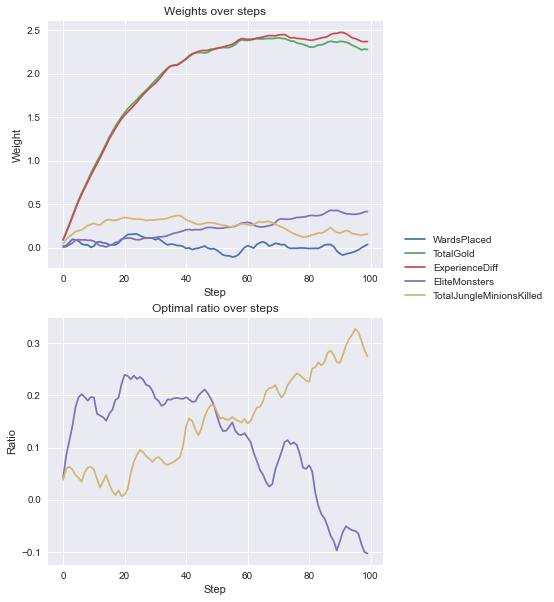

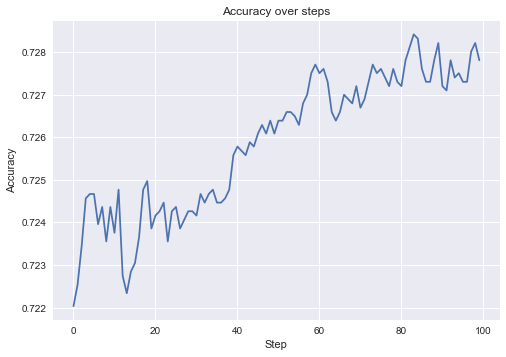

In [30]:
plot_model(vars3, vars_np4, accuracies4)

# Appendix

Some data statistics and visualizations

In [31]:
num_data = len(df_norm)
print(num_data)

9879


In [32]:
print(df_min)
print()
print(df_max)

TotalExperience             10098.0
TowersDestroyed                 0.0
EliteMonsters                   0.0
Kills                           0.0
GoldDiff                   -11467.0
Heralds                         0.0
ExperienceDiff              -9333.0
WardsDestroyed                  0.0
TotalMinionsKilled             90.0
TotalGold                   10730.0
TotalJungleMinionsKilled        0.0
AvgLevel                        4.6
Deaths                          0.0
CSPerMin                        9.0
WardsPlaced                     5.0
FirstBlood                      0.0
Dragons                         0.0
Assists                         0.0
GoldPerMin                   1073.0
dtype: float64

TotalExperience             12171.0
TowersDestroyed                 4.0
EliteMonsters                   2.0
Kills                          22.0
GoldDiff                    22934.0
Heralds                         1.0
ExperienceDiff              18666.0
WardsDestroyed                 27.0
TotalMinions

In [33]:
vars_map = {c:c.lstrip('redblu') for c in df.columns if c != 'blueWins'}
vars_map['blueWins'] = 'blueWins'
blue = df.drop(red_vars,axis=1)
red = df.drop(blue_vars,axis=1)
blue.rename(vars_map,axis=1,inplace=True)
red.rename(vars_map,axis=1,inplace=True)
blue['Team'] = ['blue' for _ in range(num_data)]
red ['Team'] = ['red'  for _ in range(num_data)]
combined_df = pd.concat([blue,red])

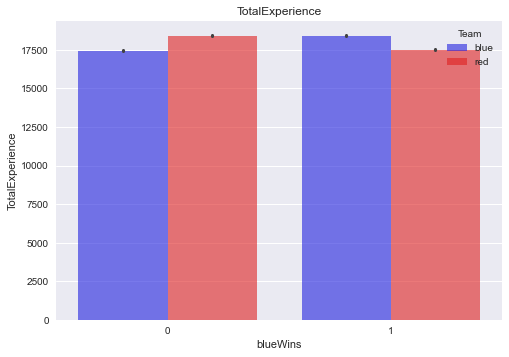

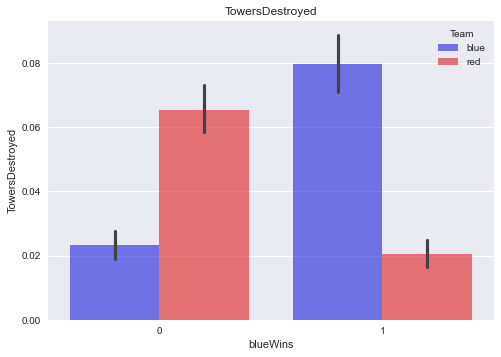

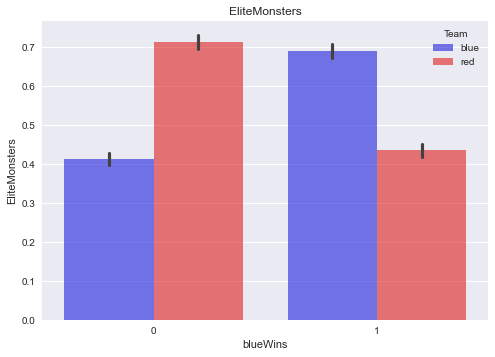

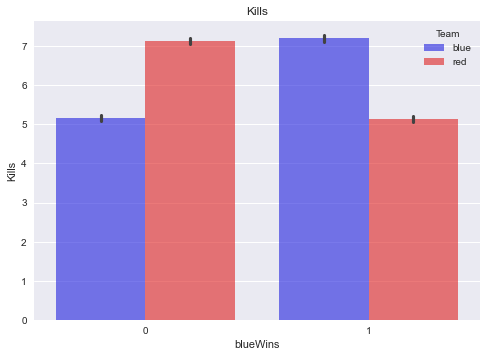

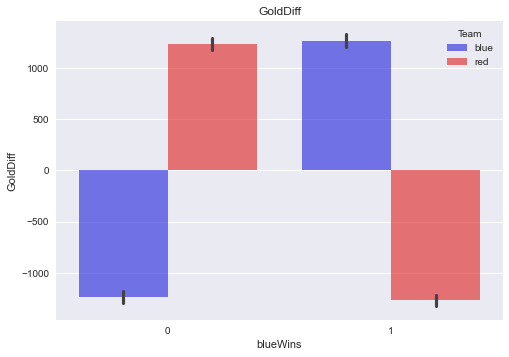

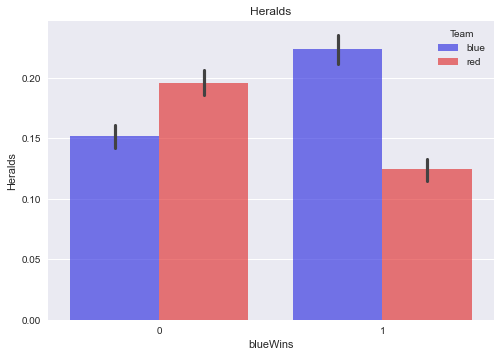

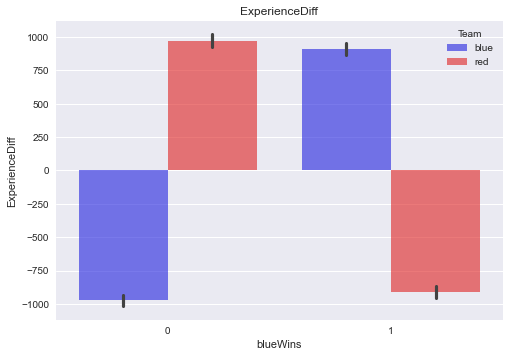

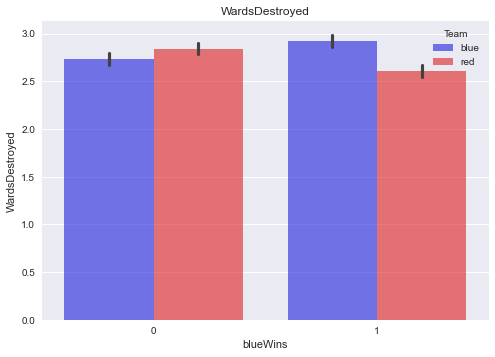

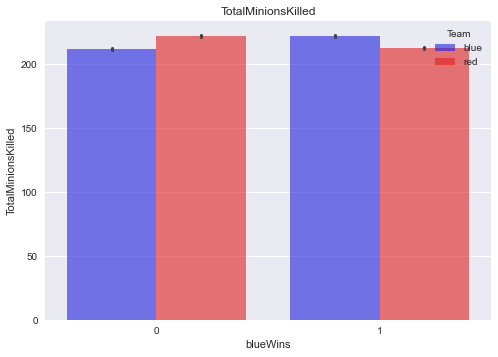

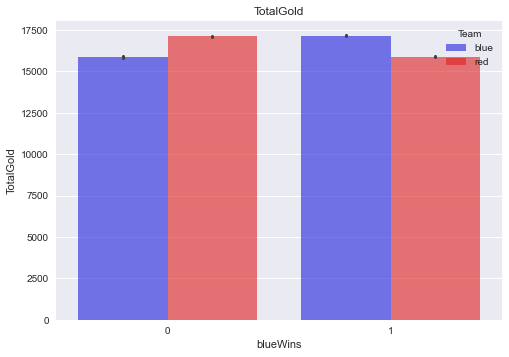

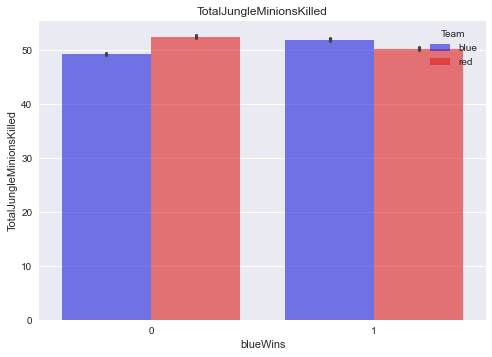

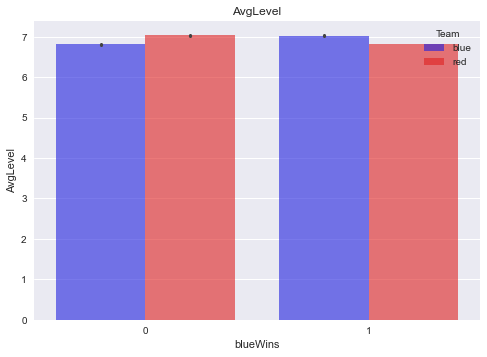

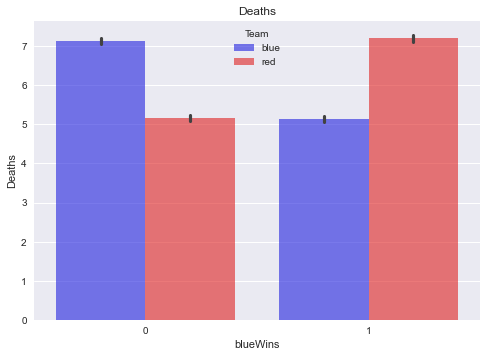

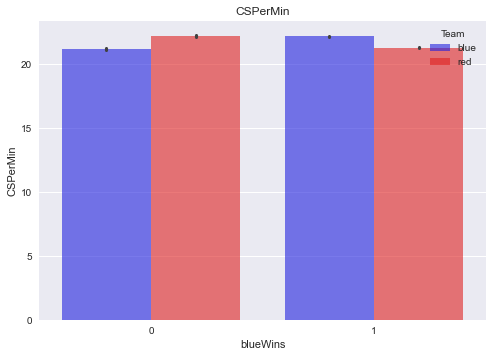

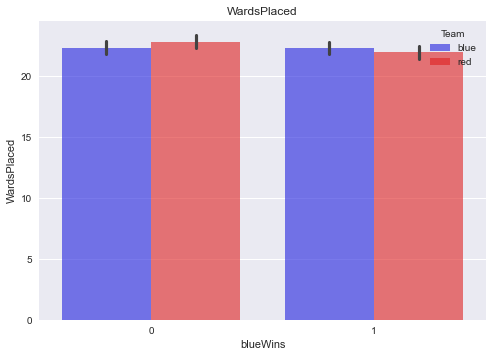

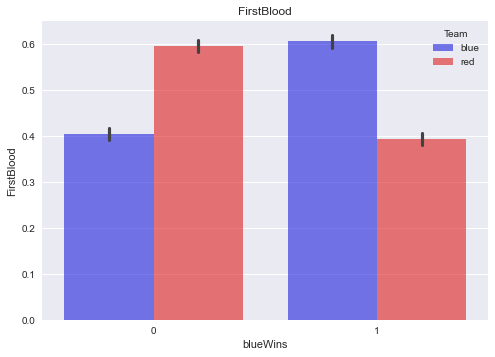

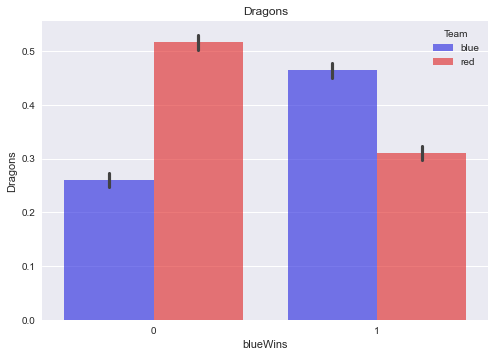

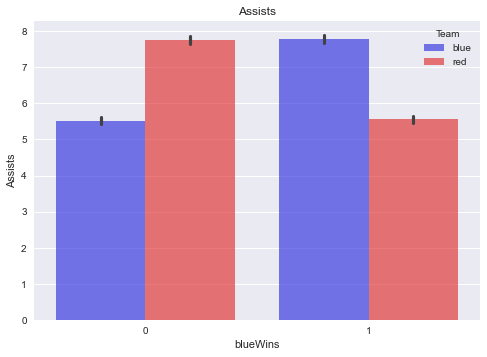

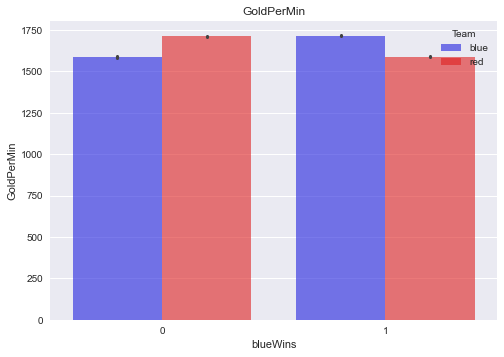

In [34]:
#most are mirrored/symmetric
for v in all_vars:
    plt.figure()
    plt.title(v)
    sns.barplot(x='blueWins', y=v
                , hue='Team', alpha=.6
                , palette=['b','r']
                , data=combined_df)
    plt.axis('on')
    plt.show()